In [ ]:
from time import time
import numpy as np
import copy as cp
import pylab as plb
%pylab inline

from scipy.integrate import odeint 
from numpy.random import permutation

from sklearn.decomposition import MiniBatchDictionaryLearning
from sklearn.feature_extraction.image import extract_patches_2d
from sklearn.feature_extraction.image import reconstruct_from_patches_2d
from sklearn import linear_model
from sklearn.feature_extraction.image import PatchExtractor as PE


Populating the interactive namespace from numpy and matplotlib


In [ ]:
#random variation of parameters
def randpar(par,var):
    '''This function adds gaussian noise to parameters stored in a dictionary. 
    var is the std of the gaussian distribution (1 = 100% of the not noisy value).'''
    flag = 0
    while flag == 0:
        temp = cp.deepcopy(par)
        for key in par.keys():
            temp[key]=par[key]*(1+var*plb.randn())
            #if temp[key] < 0:
            #    flag = 0
            #    break
            #else:
                #flag =1
            if temp[key] < 0:
                temp[key] = 0
        flag = 1            
    return temp  

## 3D Lorenz Model

In [ ]:
#3D Lorenz
def Lder(x,t,p):
    der0 = p['s']*(x[1] - x[0])
    der1 = x[0]*(p['r']-x[2]) - x[1]
    der2 = x[0]*x[1] - p['b']*x[2]
    return [der0,der1,der2]

Lpar= dict(s= 10., b =8./3, r = 28)

In [ ]:
# to find initial condition box, make sure fixed points are included
print("fp1",[-sqrt(Lpar['b']*(Lpar['r']-1))],[-sqrt(Lpar['b']*(Lpar['r']-1))],[Lpar['r']-1])
print("fp2",[sqrt(Lpar['b']*(Lpar['r']-1))],[sqrt(Lpar['b']*(Lpar['r']-1))],[Lpar['r']-1])

fp1 [-8.4852813742385695] [-8.4852813742385695] [27]
fp2 [8.4852813742385695] [8.4852813742385695] [27]


# Function to return trajectories

In [ ]:
# for fixed Delta t solve 300 trajectories
def traj_solve(N,dt,mod,mod_par,var):
    t0 = 0
    tend = 1
    Nt = (tend-t0)/float(dt)
    time = np.linspace(t0,tend,Nt)
    
    traj = np.full((N,len(time),3),-3.)
    for i in range(N):
        # add noise to the position of the fixed point
        rlvpar = randpar(mod_par,var)
        # sample randomly from both basins of attraction
        yinit = (plb.rand(3)-[0.5,0.5,0])*[40,60,50]
        traj[i,:,:] = odeint(mod,yinit,time,args = (rlvpar,))
    return traj,time    

## Example

In [ ]:
N = 20
traj,time = traj_solve(N,0.01,Lder,Lpar,0.0)

//anaconda/envs/py3/lib/python3.4/site-packages/matplotlib/figure.py:387: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "
//anaconda/envs/py3/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


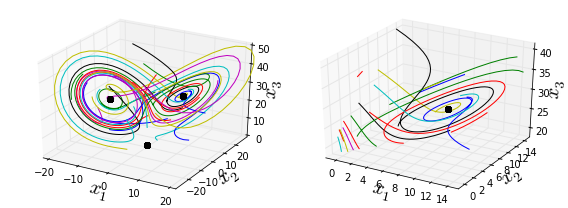

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
xminl = -1.
xmaxl = 15.
zminl  = 18.
zmaxl = 41.

fig = plt.figure(figsize=(8,3))
trajred = np.full(traj.shape,0.)
trajred[:,:,:] = traj[:,:,:]

trajred[trajred[:,:,0] < xminl] =np.nan
trajred[trajred[:,:,0] > xmaxl] =np.nan
trajred[trajred[:,:,1] < xminl] =np.nan
trajred[trajred[:,:,1] > xmaxl] =np.nan
trajred[trajred[:,:,2] < zminl] =np.nan
trajred[trajred[:,:,2] > zmaxl] =np.nan

ax = fig.add_subplot(1, 2, 1, projection='3d')
for i in range(N):
    ax.plot(traj[i,:,0], traj[i,:,1], traj[i,:,2])
    #fixed point 1    
    ax.plot([sqrt(Lpar['b']*(Lpar['r']-1))],[sqrt(Lpar['b']*(Lpar['r']-1))],[Lpar['r']-1],'ko')    
    #fixed point 2
    ax.plot([-sqrt(Lpar['b']*(Lpar['r']-1))],[-sqrt(Lpar['b']*(Lpar['r']-1))],[Lpar['r']-1],'ko')    
    #fixed point 3
    ax.plot([0],[0],[0],'ko')   
    ax.set_xlim3d(-21, 21)
    ax.set_ylim3d(-29,29)
    ax.set_zlim3d(0,50)
    ax.set_xlabel('$x_1$',size='20',rotation=0)
    ax.set_ylabel('$x_2$',size='20',rotation=0)
    ax.set_zlabel('$x_3$',size='20',rotation=0)

ax = fig.add_subplot(1, 2, 2, projection='3d')
for i in range(N):
    ax.plot(trajred[i,:,0], trajred[i,:,1], trajred[i,:,2])
    #fixed point 1    
    ax.plot([sqrt(Lpar['b']*(Lpar['r']-1))],[sqrt(Lpar['b']*(Lpar['r']-1))],[Lpar['r']-1],'ko')    
    #fixed point 2
    ax.plot([-sqrt(Lpar['b']*(Lpar['r']-1))],[-sqrt(Lpar['b']*(Lpar['r']-1))],[Lpar['r']-1],'ko')    
    #fixed point 3
    ax.plot([0],[0],[0],'ko')   
    ax.set_xlim3d(xminl, xmaxl)
    ax.set_ylim3d(xminl, xmaxl)
    ax.set_zlim3d(zminl,zmaxl)
    ax.set_xlabel('$x_1$',size='20',rotation=0)
    ax.set_ylabel('$x_2$',size='20',rotation=0)
    ax.set_zlabel('$x_3$',size='20',rotation=0)
#ax.legend()
fig.show()
tight_layout()
#fig.savefig("3d_traj.pdf", bbox_inches='tight')

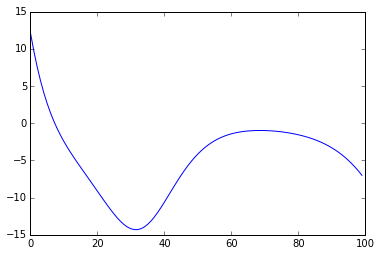

In [ ]:
plot(traj[0,:,0])

# trajectories to samples of f

In [ ]:
def traj_der(traj,time):
    N,Nt,Nvar = np.shape(traj)
    dt = time[1]- time[0]
    trajder = np.full((N,Nt-1,Nvar),-3.)
    for i in range(N):
        for j in range(Nt-1):
            for k in range(Nvar):
                trajder[i,j,k] = (traj[i,j+1,k]-traj[i,j,k])/dt
                
    return trajder           

In [ ]:
time[1]-time[0]

0.010101010101010102

## Example

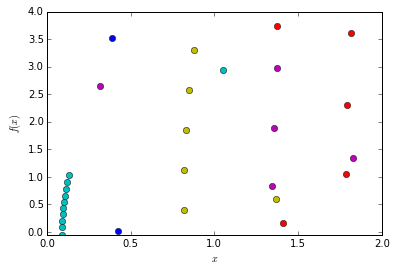

In [ ]:
trajder = traj_der(traj,time)
for i in range(N):
    plot(traj[i,:-1,1],trajder[i,:,1],'o')
    xlabel("$x$")
    ylabel("$f(x)$")
    xlim((0,2))
    ylim((-0.05,4))

## Scale and discretize measurments to fit on a 32x32x32 grid

In [ ]:
#convert discrete index to x1,x2 position in the model

#continuous scaling
#0 -> -21
#31 -> 21
def ind_to_x(i):
    return i*42./31. -21
#0 -> -29
#31 -> 29
def ind_to_y(i):
    return i*58/31. -29

#0 -> 0
#31 -> 30
def ind_to_z(i):
    return i*52/31. -2.



In [ ]:
# convert x position to discrete index

#-21 -> 0
#21 -> 31
def x_to_ind(x):
    ind = x*31./42. +31./2.
    return int(round(ind)) 
#-29 -> 0
#29 -> 31
def y_to_ind(x):
    ind = x*31./58. +31./2.
    return int(round(ind)) 
#0 -> 0
#30 -> 31
def z_to_ind(x):
    ind = x*31./52.+31./26.
    return int(round(ind))

In [ ]:
def traj_to_f_meas(traj,trajder,jj):
    N,Nt,Nvar = np.shape(traj)
    f_meas = np.full((N,32,32,32),-100.)
    for k in range(N):
        for i in range(Nt-1):
            #make sure index fits into the 32x32x32array
            ind0 = x_to_ind((traj[k,i+1,0]+traj[k,i,0])/2.)
            ind1 = y_to_ind((traj[k,i+1,1]+traj[k,i,1])/2.)
            ind2 = z_to_ind((traj[k,i+1,2]+traj[k,i,2])/2.)
            if  (ind0 < 32) and (ind1 < 32) and (ind2 < 32):
                if (ind0 >= 0) and (ind1 >= 0) and (ind2 >= 0):
                    f_meas[k,ind0,ind1,ind2] = trajder[k,i,jj]
    return f_meas          

def traj_to_f_m(traj,trajder,Ntraj,jj):
    N,Nt,Nvar = np.shape(traj)
    f_m = np.full((32,32,32),-100.)
    touched = np.full((32,32,32),0.)
    s = sorted(permutation(N)[:Ntraj])
    for k in s:
        for i in range(Nt-1):
            #make sure index fits into the 32x32x32array
            ind0 = x_to_ind((traj[k,i+1,0]+traj[k,i,0])/2.)
            ind1 = y_to_ind((traj[k,i+1,1]+traj[k,i,1])/2.)
            ind2 = z_to_ind((traj[k,i+1,2]+traj[k,i,2])/2.)
            if  (ind0 < 32) and (ind1 < 32) and (ind2 < 32):
                if (ind0 >= 0) and (ind1 >= 0) and (ind2 >= 0):
                    if touched[ind0,ind1,ind2] == 0.:
                        f_m[ind0,ind1,ind2] = trajder[k,i,jj]
                    else:    
                        f_m[ind0,ind1,ind2] += trajder[k,i,jj]
                        
                    touched[ind0,ind1,ind2] +=1.
                    
    for i in range(32):
        for j in range(32):
            for k in range(32):
                if touched[i,j,k]!=0.:
                    f_m[i,j,k]/=float(touched[i,j,k])
    return f_m

# Sparsely reconstruct under-sampled data in basis

In [ ]:
def patch_rec(data,basis,nmeas,ps1,ps2,real_data = True):
    clf = linear_model.Lasso(alpha=0.00001, copy_X=True, fit_intercept=False, max_iter=5000, tol=0.00000000001)

    #create array for reconstructed data
    recdata = np.full(data.shape,0.)
    
    #mean normalize data
#    intercept = np.mean(data, axis=0)
#    data -= intercept

    #for each patch:
    #(1) downsample data and down sample basis
    #(2) find sparse representation
    #(3) reconstruct patch from sparese representation and original basis
    for i in range(len(data[:,0])):
        #(1) and (2)
        # generate list of random, unique samples
        if real_data == False:
            rm = sorted(permutation(ps1*ps2)[:nmeas])
            clf.fit(basis[:,rm].T, data[i,rm])
            #(3) reconstruct patch from fit coefficients
            recdata[i,:] = np.dot(basis.T,clf.coef_)
        else:
            rm = [j for j in range(ps1*ps2) if data[i,j]!=-100.]
            if rm == []:
                print("not enough data!\n")
                #print(i)
                continue
            #elif len(rm) == ps1*ps2:
                #recdata[i,:] = data[i,:]
                #continue
        clf.fit(basis[:,rm].T, data[i,rm])
        #(3) reconstruct patch from fit coefficients
        recdata[i,:] = np.dot(basis.T,clf.coef_)
    
    #add mean normalization back
#    recdata += intercept
#    data += intercept
    return recdata

In [ ]:
def image_rec(original,basis,nmeas,ps1,ps2,real_data = True):
    patch_size = (ps1,ps2)
    imsize = original.shape
    #take one function and turn to patches
    print(patch_size)
    data = extract_patches_2d(original, patch_size)
    data = data.reshape(data.shape[0], -1)
    print("shape of data",data.shape)
    datarec = patch_rec(data,basis,nmeas,ps1,ps2,real_data= real_data)
    #turn datarec into image
    datarec = datarec.reshape(len(datarec), *patch_size)
    rec = rec_from_patches_2d(datarec, imsize)
    return rec

In [ ]:
def rec_from_patches_2d(patches, image_size):
    """Reconstruct the image from all of its patches.
    Patches are assumed to overlap and the image is constructed by filling in
    the patches from left to right, top to bottom, averaging the overlapping
    regions.
    Read more in the :ref:`User Guide <image_feature_extraction>`.
    Parameters
    ----------
    patches : array, shape = (n_patches, patch_height, patch_width) or
        (n_patches, patch_height, patch_width, n_channels)
        The complete set of patches. If the patches contain colour information,
        channels are indexed along the last dimension: RGB patches would
        have `n_channels=3`.
    image_size : tuple of ints (image_height, image_width) or
        (image_height, image_width, n_channels)
        the size of the image that will be reconstructed
    Returns
    -------
    image : array, shape = image_size
        the reconstructed image
    """
    from itertools import product as pd
    
    i_h, i_w = image_size[:2]
    p_h, p_w = patches.shape[1:3]
    img = np.zeros(image_size)
    touched = np.zeros(image_size)
    # compute the dimensions of the patches array
    n_h = i_h - p_h + 1
    n_w = i_w - p_w + 1
    for p, (i, j) in zip(patches, pd(range(n_h), range(n_w))):
        img[i:i + p_h, j:j + p_w] += p
        touched[i:i + p_h, j:j + p_w] +=1

    #story checks out until here, I think    
    for i in range(i_h):
        for j in range(i_w):
            # divide by the amount of overlap
            # XXX: is this the most efficient way? memory-wise yes, cpu wise?
            
            #img[i, j] /= float(min(i + 1, p_h, i_h - i) *
             #                  min(j + 1, p_w, i_w - j))
            img[i,j]/=float(touched[i,j])    
    return img

# learn basis from data

In [ ]:
#number of trajectories to include
def f_prep(N,NTraj,f_meas,b_size):
    #start with a random basis
    r_basis = np.random.rand(100,b_size)
    _,l1,l2 = f_meas.shape
    #sample randomly from all trajectories
    s = sorted(permutation(N)[:NTraj])
    f_m = np.full((l1,l2),-100.)
    #for fixed (x1,x2) average over all trajectory measurements (only those values that are not -100)
    for i in range(l1):
        for j in range(l2):
            col = [f_meas[k,i,j] for k in s if f_meas[k,i,j]!= -100.]
            if col == []:
                f_m[i,j] = -100.
            else:
                f_m[i,j] = np.mean(col)
    return f_m,r_basis

In [ ]:
# learn basis, return reconstruction and basis
def basis_and_rec(f_m,init_basis):
    print("starting rec...")
    b_size = init_basis.shape
    b_s = int(sqrt(b_size[1]))
    #print(b_size)
    #reconstruct sparsely in random basis
    print("first rec in random basis")
    #rec = image_rec(f_m,init_basis,1,b_s,b_s,real_data = True)
    rec = np.full(f_m.shape,0.)
    rec[:] = f_m[:]
    # resize to basis size
    datarec = extract_patches_2d(rec,(b_s,b_s))
    datarec = datarec.reshape(datarec.shape[0], -1)
    #fill in not measured values with a random number
    for i in range(datarec.shape[0]):
        m = [np.random.rand() for j in range(len(datarec[i,:])) if datarec[i,j]==-100.]
        datarec[i][datarec[i]==-100.]= m
    print("learning basis")
    tempdic = MiniBatchDictionaryLearning(n_components=30, alpha=0.1, n_iter=10000 )
    V = tempdic.fit(datarec).components_
    print("second rec, in learned basis")
    rec = image_rec(f_m,V,1,b_s,b_s,real_data = True)
    
    return V,rec

# measure Error

In [ ]:
def norm_1(original,reconstructed):
    # reshape input to one dimensional arrays
    d = np.reshape(original,-1)
    r = np.reshape(reconstructed,-1)
    if np.linalg.norm(r)!=0.:
        norm = 1. - abs(np.dot(d,r))/np.linalg.norm(d)/np.linalg.norm(r)
    else:
        norm = 1. 
    return norm

def norm_2(original,reconstructed):
    # reshape input to one dimensional arrays
    d = np.reshape(original,-1)
    r = np.reshape(reconstructed,-1)

    norm = np.linalg.norm(d-r)
    return norm

def norm_3(original,reconstructed):
    # reshape input to one dimensional arrays
    d = np.reshape(original,-1)
    r = np.reshape(reconstructed,-1)

    norm = np.linalg.norm(d-r)/np.linalg.norm(d)
    return norm

# Running Script

In [ ]:
#create reference function f_ref
f_ref = np.full((32,32,32),0.)
for i in range(32):
    for j in range(32):
        for k in range(32):
            f_ref[i,j,k] = Lder([ind_to_x(i),ind_to_y(j),ind_to_z(k)],1,Lpar)[0]
f_ref = f_ref.reshape((-1,32),order = 'C')            
# generate trajectories
N = 10000
traj,time = traj_solve(N,0.001,Lder,Lpar,0.0)        
#generate derivatives
trajder = traj_der(traj,time)
#rescale to sample f
#f_meas = reshape(traj_to_f_meas(traj,trajder,0),(N,-1,32),order = 'C')

NameError: name 'ind_to_x' is not defined

In [ ]:
Ntraj = 1000
b_size = 20*20
#f_m,r_basis = f_prep(1000,Ntraj,f_meas,b_size)
f_mtest = reshape(traj_to_f_m(traj,trajder,Ntraj,0),(-1,32),order = 'C')

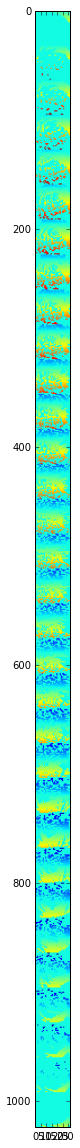

In [ ]:
#f_meas = traj_to_f_meas(traj,trajder,0)
figure(figsize=(1,20))
imshow(f_mtest)

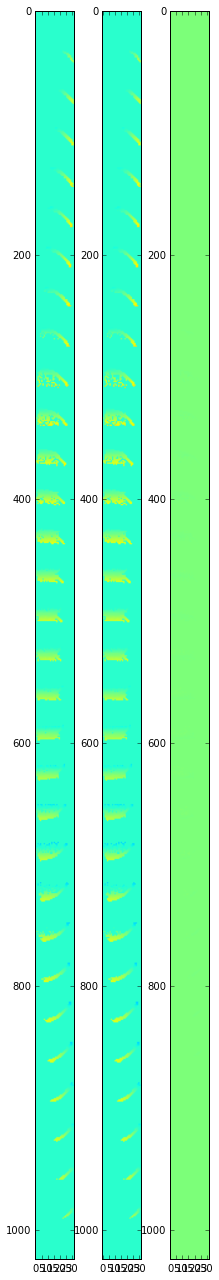

In [ ]:
vmin = np.min(f_ref)
vmax = np.max(f_ref)
figure(figsize = (3,20))
subplot(1,3,1)
imshow(f_m,vmin=vmin,vmax=vmax)
subplot(1,3,2)
imshow(f_mtest,vmin=vmin,vmax=vmax)
subplot(1,3,3)
imshow(f_m-f_mtest,vmin=vmin,vmax=vmax)
tight_layout()

In [ ]:
V,rec = basis_and_rec(f_m,r_basis)

starting rec...
first rec in random basis
(20, 20)
shape of data (13065, 400)
not enough data!

52
not enough data!

53
not enough data!

54
not enough data!

55
not enough data!

56
not enough data!

65
not enough data!

66
not enough data!

67
not enough data!

68
not enough data!

69
not enough data!

78
not enough data!

79
not enough data!

80
not enough data!

81
not enough data!

82
not enough data!

91
not enough data!

92
not enough data!

93
not enough data!

94
not enough data!

95
not enough data!

96
not enough data!

97
not enough data!

98
not enough data!

99
not enough data!

100
not enough data!

101
not enough data!

102
not enough data!

103
not enough data!

104
not enough data!

105
not enough data!

106
not enough data!

107
not enough data!

108
not enough data!

109
not enough data!

110
not enough data!

111
not enough data!

112
not enough data!

113
not enough data!

114
not enough data!

115
not enough data!

116
not enough data!

117
not enough data!

118


//anaconda/envs/py3/lib/python3.4/site-packages/sklearn/linear_model/coordinate_descent.py:444: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.4/site-packages/sklearn/linear_model/least_angle.py:170: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  elif Gram == 'auto':



second rec, in learned basis
(20, 20)
shape of data (13065, 400)
not enough data!

52
not enough data!

53
not enough data!

54
not enough data!

55
not enough data!

56
not enough data!

65
not enough data!

66
not enough data!

67
not enough data!

68
not enough data!

69
not enough data!

78
not enough data!

79
not enough data!

80
not enough data!

81
not enough data!

82
not enough data!

91
not enough data!

92
not enough data!

93
not enough data!

94
not enough data!

95
not enough data!

96
not enough data!

97
not enough data!

98
not enough data!

99
not enough data!

100
not enough data!

101
not enough data!

102
not enough data!

103
not enough data!

104
not enough data!

105
not enough data!

106
not enough data!

107
not enough data!

108
not enough data!

109
not enough data!

110
not enough data!

111
not enough data!

112
not enough data!

113
not enough data!

114
not enough data!

115
not enough data!

116
not enough data!

117
not enough data!

118
not enough d

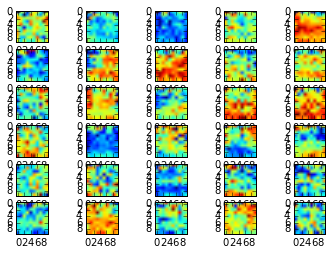

In [ ]:
for i,comp in enumerate(V):
    subplot(6,5,i+1)
    imshow(reshape(comp,(20,20)))

In [ ]:
rec

(1024, 32)

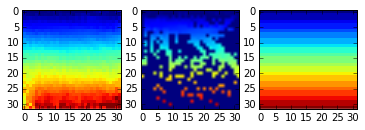

In [ ]:
vmin = np.min(f_ref[320:32+320,:])
vmax = np.max(f_ref[320:32+320,:])
subplot(1,3,1)
imshow(rec,vmax =vmax,vmin=vmin,interpolation = 'none')
subplot(1,3,2)
imshow(f_m[320:32+320,:],vmax =vmax,vmin=vmin)
subplot(1,3,3)
imshow(f_ref[320:32+320,:],vmax =vmax,vmin=vmin,interpolation = 'none')

In [ ]:
patches.size

67600

In [ ]:
1+1

2

In [ ]:
Nave = 20
# reference function
f_ref = np.full((32,32,32),0.)
for i in range(32):
    for j in range(32):
        for k in range(32):
            f_ref[i,j,k] = Lder([ind_to_x(i),ind_to_y(j),ind_to_z(k)],1,Lpar)[0]
#f_ref = f_ref.reshape((-1,32),order = 'C')  

dt_list = [0.5,0.1,0.05,0.01,0.005,0.001]
Ntraj_list = [500,1000,5000,10000]
b_size_list = [10*10]
N=np.max(Ntraj_list)
res = np.full((len(Ntraj_list)*len(b_size_list)*len(dt_list),6),0.)   
k = -1
for b_size in b_size_list:
    for dt in dt_list:#:
        # generate trajectories
        traj,time = traj_solve(N,dt,Lder,Lpar,0.0)
        #generate derivatives
        trajder = traj_der(traj,time)
        #rescale to sample f
        #f_meas = reshape(traj_to_f_meas(traj,trajder,0),(N,-1,32),order = 'C')
        #print(f_meas.shape)

        #sample NTraj trajectories
        for Ntraj in Ntraj_list:
            print('dt = '+str(dt))
            print('Ntraj = '+str(Ntraj))
            t_rec = np.full((Nave,3),0.)
            k+=1
            for i in range(Nave):
                #f_m,r_basis = f_prep(10000,Ntraj,f_meas,b_size)
                r_basis = np.random.rand(100,b_size)
                f_m = traj_to_f_m(traj,trajder,Ntraj,0)
                # select random 32 by 32 frame for learning and reconstruction
                # 1) pick variable, 2)pick slice
                xv,sl = [permutation(3)[0],permutation(32)[0]]
                l=[]
                if xv == 0:
                    f_mr = f_m[sl,:,:]
                    f_refr = f_ref[sl,:,:]
                    for kk in range(32):
                        l.append(f_ref[i,:,:])
                elif xv ==1:    
                    f_mr = f_m[:,sl,:]
                    f_refr = f_ref[:,sl,:]
                    for kk in range(32):
                        l.append(f_ref[:,:,i])
                elif xv ==2:
                    f_mr = f_m[:,:,sl]
                    f_refr = f_ref[:,:,sl]
                    for kk in range(32):
                        l.append(f_ref[:,:,i])
                # learn basis on all slices parallel to reconstruction slice and reconstruct
                ps = int(sqrt(b_size))
                pe = PE((ps,ps))
                patches = reshape(pe.transform(array(l)),(-1,b_size),order='C')
                for ii in range(patches.shape[0]):
                    m = [np.random.rand() for jj in range(len(patches[ii,:])) if patches[ii,jj]==-100.]
                    patches[ii][patches[ii]==-100.]= m
                tempdic = MiniBatchDictionaryLearning(n_components=30, alpha=0.1, n_iter=5000 )
                V = tempdic.fit(patches).components_  
                rec = image_rec(f_mr,V,1,ps,ps)
                t_rec[i]=[norm_1(f_refr,rec),norm_2(f_refr,rec),norm_3(f_refr,rec)]
            res[k,:3] = [dt,Ntraj,b_size]
            res[k,3:]= np.mean(t_rec,0)
        np.savetxt("3d_err_dt_Ntraj_"+str(dt)+".txt",res)       

dt = 0.5
Ntraj = 500
(10, 10)

//anaconda/envs/py3/lib/python3.4/site-packages/sklearn/linear_model/least_angle.py:170: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  elif Gram == 'auto':
//anaconda/envs/py3/lib/python3.4/site-packages/sklearn/linear_model/coordinate_descent.py:444: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)



shape of data (529, 100)
not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

no

//anaconda/envs/py3/lib/python3.4/site-packages/sklearn/linear_model/least_angle.py:285: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=1.221e-03, with an active set of 2 regressors, and the smallest cholesky pivot element being 7.146e-08
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.4/site-packages/sklearn/linear_model/least_angle.py:285: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=1.173e-03, with an active set of 2 regressors, and the smallest cholesky pivot element being 7.146e-08
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.4/site-packages/sklearn/linear_model/least_angle.py:285: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=1.324e-03, with an active set of 2 regressors, and the smallest cholesky pivot element being 7.146e-08
  ConvergenceWarning)
//anaconda/envs/py3/lib/pyth


not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

(10, 10)
shape of data (529, 100)
not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough 

//anaconda/envs/py3/lib/python3.4/site-packages/sklearn/linear_model/least_angle.py:285: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 7 iterations, i.e. alpha=1.812e+00, with an active set of 3 regressors, and the smallest cholesky pivot element being 2.581e-08
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.4/site-packages/sklearn/linear_model/least_angle.py:285: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 8 iterations, i.e. alpha=1.809e+00, with an active set of 4 regressors, and the smallest cholesky pivot element being 2.581e-08
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.4/site-packages/sklearn/linear_model/least_angle.py:310: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 9 iterations, alpha=1.809e+00, previous alpha=1.806e+00, with an active set of 4 regressors.
  ConvergenceWarning)
//anaconda/


not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

(10, 10)
shape of data (529, 100)
not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough 

//anaconda/envs/py3/lib/python3.4/site-packages/sklearn/linear_model/least_angle.py:285: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=2.104e+00, with an active set of 4 regressors, and the smallest cholesky pivot element being 2.356e-08
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.4/site-packages/sklearn/linear_model/least_angle.py:285: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 8 iterations, i.e. alpha=1.052e+00, with an active set of 6 regressors, and the smallest cholesky pivot element being 2.980e-08
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.4/site-packages/sklearn/linear_model/least_angle.py:310: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 9 iterations, alpha=1.052e+00, previous alpha=1.049e+00, with an active set of 6 regressors.
  ConvergenceWarning)
//anaconda/


not enough data!

not enough data!

not enough data!

not enough data!

(10, 10)

//anaconda/envs/py3/lib/python3.4/site-packages/sklearn/linear_model/least_angle.py:310: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 6 iterations, alpha=7.040e-03, previous alpha=6.959e-03, with an active set of 3 regressors.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.4/site-packages/sklearn/linear_model/least_angle.py:285: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=3.133e-03, with an active set of 4 regressors, and the smallest cholesky pivot element being 2.220e-16
  ConvergenceWarning)



shape of data (529, 100)
not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

no

//anaconda/envs/py3/lib/python3.4/site-packages/sklearn/linear_model/least_angle.py:310: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 5 iterations, alpha=3.132e-03, previous alpha=3.121e-03, with an active set of 4 regressors.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.4/site-packages/sklearn/linear_model/least_angle.py:285: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 13 iterations, i.e. alpha=3.084e-03, with an active set of 5 regressors, and the smallest cholesky pivot element being 2.107e-08
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.4/site-packages/sklearn/linear_model/least_angle.py:285: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 23 iterations, i.e. alpha=1.530e-03, with an active set of 9 regressors, and the smallest cholesky pivot element being 1.490e-08
  ConvergenceWarning)
//anacond


not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enoug

//anaconda/envs/py3/lib/python3.4/site-packages/sklearn/linear_model/least_angle.py:285: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 35 iterations, i.e. alpha=3.036e-03, with an active set of 27 regressors, and the smallest cholesky pivot element being 6.409e-08
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.4/site-packages/sklearn/linear_model/least_angle.py:285: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 35 iterations, i.e. alpha=2.904e-03, with an active set of 27 regressors, and the smallest cholesky pivot element being 6.409e-08
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.4/site-packages/sklearn/linear_model/least_angle.py:285: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 12 iterations, i.e. alpha=3.289e-03, with an active set of 10 regressors, and the smallest cholesky pivot element being 9.996e-08
  ConvergenceWarning)



(10, 10)
shape of data (529, 100)
not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough 

//anaconda/envs/py3/lib/python3.4/site-packages/sklearn/linear_model/least_angle.py:285: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 17 iterations, i.e. alpha=1.684e-03, with an active set of 11 regressors, and the smallest cholesky pivot element being 1.490e-08
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.4/site-packages/sklearn/linear_model/least_angle.py:285: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 17 iterations, i.e. alpha=1.620e-03, with an active set of 11 regressors, and the smallest cholesky pivot element being 1.490e-08
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.4/site-packages/sklearn/linear_model/least_angle.py:310: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 18 iterations, alpha=1.679e-03, previous alpha=1.441e-03, with an active set of 11 regressors.
  ConvergenceWarning)
//ana


not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enoug

//anaconda/envs/py3/lib/python3.4/site-packages/sklearn/linear_model/least_angle.py:310: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 13 iterations, alpha=2.074e-03, previous alpha=2.074e-03, with an active set of 6 regressors.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.4/site-packages/sklearn/linear_model/least_angle.py:285: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 14 iterations, i.e. alpha=1.033e-03, with an active set of 6 regressors, and the smallest cholesky pivot element being 2.980e-08
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.4/site-packages/sklearn/linear_model/least_angle.py:310: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 15 iterations, alpha=1.033e-03, previous alpha=1.033e-03, with an active set of 6 regressors.
  Convergence


shape of data (529, 100)
not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

no

//anaconda/envs/py3/lib/python3.4/site-packages/sklearn/linear_model/least_angle.py:310: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 5 iterations, alpha=1.653e-02, previous alpha=1.650e-02, with an active set of 4 regressors.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.4/site-packages/sklearn/linear_model/least_angle.py:285: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 8 iterations, i.e. alpha=2.353e-03, with an active set of 6 regressors, and the smallest cholesky pivot element being 3.332e-08
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.4/site-packages/sklearn/linear_model/least_angle.py:285: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 9 iterations, i.e. alpha=2.332e-03, with an active set of 7 regressors, and the smallest cholesky pivot element being 3.332e-08
  ConvergenceWarning)
//anaconda/


not enough data!

(10, 10)
shape of data (529, 100)
not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough 

//anaconda/envs/py3/lib/python3.4/site-packages/sklearn/linear_model/least_angle.py:310: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 34 iterations, alpha=1.291e-03, previous alpha=1.273e-03, with an active set of 23 regressors.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.4/site-packages/sklearn/linear_model/least_angle.py:285: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 28 iterations, i.e. alpha=2.665e-03, with an active set of 10 regressors, and the smallest cholesky pivot element being 8.093e-08
  ConvergenceWarning)



not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enoug

//anaconda/envs/py3/lib/python3.4/site-packages/sklearn/linear_model/least_angle.py:285: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 33 iterations, i.e. alpha=1.647e-03, with an active set of 11 regressors, and the smallest cholesky pivot element being 2.107e-08
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.4/site-packages/sklearn/linear_model/least_angle.py:285: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 33 iterations, i.e. alpha=1.645e-03, with an active set of 11 regressors, and the smallest cholesky pivot element being 2.220e-16
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.4/site-packages/sklearn/linear_model/least_angle.py:285: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 33 iterations, i.e. alpha=1.593e-03, with an active set of 11 regressors, and the smallest cholesky pivot element being 3.495e-08
  ConvergenceWarning)
//anaconda/envs/py3/li


shape of data (529, 100)
not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

no

//anaconda/envs/py3/lib/python3.4/site-packages/sklearn/linear_model/least_angle.py:310: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 16 iterations, alpha=7.374e-03, previous alpha=7.374e-03, with an active set of 9 regressors.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.4/site-packages/sklearn/linear_model/least_angle.py:285: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 18 iterations, i.e. alpha=3.110e-03, with an active set of 8 regressors, and the smallest cholesky pivot element being 2.107e-08
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.4/site-packages/sklearn/linear_model/least_angle.py:310: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 19 iterations, alpha=3.110e-03, previous alpha=3.110e-03, with an active set of 8 regressors.
  Convergence


not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enoug

//anaconda/envs/py3/lib/python3.4/site-packages/sklearn/linear_model/least_angle.py:285: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=1.009e-03, with an active set of 4 regressors, and the smallest cholesky pivot element being 2.220e-16
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.4/site-packages/sklearn/linear_model/least_angle.py:285: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=1.009e-03, with an active set of 4 regressors, and the smallest cholesky pivot element being 2.356e-08
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.4/site-packages/sklearn/linear_model/least_angle.py:285: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=1.009e-03, with an active set of 4 regressors, and the smallest cholesky pivot element being 2.107e-08
  ConvergenceWarning)
//anaconda/envs/py3/lib/pyth


not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

(10, 10)
shape of data (529, 100)
(10, 10)
shape of data (529, 100)
(10, 10)
shape of data (529, 100)
not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data

//anaconda/envs/py3/lib/python3.4/site-packages/sklearn/linear_model/least_angle.py:310: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 4 iterations, alpha=1.427e-01, previous alpha=1.423e-01, with an active set of 3 regressors.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.4/site-packages/sklearn/linear_model/least_angle.py:285: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=8.994e-03, with an active set of 3 regressors, and the smallest cholesky pivot element being 1.490e-08
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.4/site-packages/sklearn/linear_model/least_angle.py:310: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 4 iterations, alpha=8.994e-03, previous alpha=8.969e-03, with an active set of 3 regressors.
  ConvergenceWar


not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

(10, 10)
shape of data (529, 100)
not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough 

//anaconda/envs/py3/lib/python3.4/site-packages/sklearn/linear_model/least_angle.py:285: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 19 iterations, i.e. alpha=2.582e-02, with an active set of 5 regressors, and the smallest cholesky pivot element being 5.576e-08
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.4/site-packages/sklearn/linear_model/least_angle.py:285: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 19 iterations, i.e. alpha=2.582e-02, with an active set of 5 regressors, and the smallest cholesky pivot element being 2.107e-08
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.4/site-packages/sklearn/linear_model/least_angle.py:285: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 19 iterations, i.e. alpha=2.582e-02, with an active set of 5 regressors, and the smallest cholesky pivot element being 5.268e-08
  ConvergenceWarning)
//anaconda/envs/py3/lib/p


not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enoug

//anaconda/envs/py3/lib/python3.4/site-packages/sklearn/linear_model/least_angle.py:310: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 5 iterations, alpha=5.896e-02, previous alpha=5.657e-02, with an active set of 4 regressors.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.4/site-packages/sklearn/linear_model/least_angle.py:285: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=4.387e-02, with an active set of 4 regressors, and the smallest cholesky pivot element being 2.356e-08
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.4/site-packages/sklearn/linear_model/least_angle.py:310: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 5 iterations, alpha=4.385e-02, previous alpha=4.208e-02, with an active set of 4 regressors.
  ConvergenceWar


not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

(10, 10)
shape of data (529, 100)
not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

(10, 10)
shape of data (529, 100)
not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough da

//anaconda/envs/py3/lib/python3.4/site-packages/sklearn/linear_model/least_angle.py:285: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 14 iterations, i.e. alpha=1.617e-02, with an active set of 10 regressors, and the smallest cholesky pivot element being 1.054e-08
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.4/site-packages/sklearn/linear_model/least_angle.py:310: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 15 iterations, alpha=1.591e-02, previous alpha=1.536e-02, with an active set of 10 regressors.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.4/site-packages/sklearn/linear_model/least_angle.py:285: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 14 iterations, i.e. alpha=2.567e-02, with an active set of 10 regressors, and the smallest cholesky pivot element being 2.220e-16
  ConvergenceWarning)
//ana


shape of data (529, 100)
(10, 10)
shape of data (529, 100)
not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

(10, 10)
shape of data (529, 100)
not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

(10, 10)
shape of data (529, 100)
not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enou

//anaconda/envs/py3/lib/python3.4/site-packages/sklearn/linear_model/least_angle.py:285: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 7 iterations, i.e. alpha=1.463e-02, with an active set of 3 regressors, and the smallest cholesky pivot element being 2.581e-08
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.4/site-packages/sklearn/linear_model/least_angle.py:285: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 7 iterations, i.e. alpha=1.463e-02, with an active set of 3 regressors, and the smallest cholesky pivot element being 1.490e-08
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.4/site-packages/sklearn/linear_model/least_angle.py:285: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 7 iterations, i.e. alpha=1.463e-02, with an active set of 3 regressors, and the smallest cholesky pivot element being 1.825e-08
  ConvergenceWarning)
//anaconda/envs/py3/lib/pyth


not enough data!

(10, 10)
shape of data (529, 100)
not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough 

//anaconda/envs/py3/lib/python3.4/site-packages/sklearn/linear_model/least_angle.py:285: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 10 iterations, i.e. alpha=1.357e-03, with an active set of 6 regressors, and the smallest cholesky pivot element being 2.980e-08
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.4/site-packages/sklearn/linear_model/least_angle.py:285: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 10 iterations, i.e. alpha=1.357e-03, with an active set of 6 regressors, and the smallest cholesky pivot element being 1.490e-08
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.4/site-packages/sklearn/linear_model/least_angle.py:310: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 14 iterations, alpha=1.337e-03, previous alpha=1.334e-03, with an active set of 7 regressors.
  ConvergenceWarning)
//anacon


(10, 10)
shape of data (529, 100)
(10, 10)
shape of data (529, 100)
not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

(10, 10)
shape of data (529, 10

//anaconda/envs/py3/lib/python3.4/site-packages/sklearn/linear_model/least_angle.py:285: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 12 iterations, i.e. alpha=4.370e-02, with an active set of 10 regressors, and the smallest cholesky pivot element being 4.712e-08
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.4/site-packages/sklearn/linear_model/least_angle.py:310: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 13 iterations, alpha=4.370e-02, previous alpha=4.370e-02, with an active set of 10 regressors.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.4/site-packages/sklearn/linear_model/least_angle.py:285: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 5 iterations, i.e. alpha=2.422e-01, with an active set of 3 regressors, and the smallest cholesky pivot element being 7.146e-08
  ConvergenceWarning)
//anaco


not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

(10, 10)
shape of data (529, 100)
(10, 10)
shape of data (529, 100)
(10, 10)
shape of data (529, 100)
not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

(10, 10)
shape of data (529, 100)
not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

(10, 10)
shape of data (529, 100)
not enough data!

not enough data!

not enough data!

n

//anaconda/envs/py3/lib/python3.4/site-packages/sklearn/linear_model/least_angle.py:285: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 23 iterations, i.e. alpha=2.264e-02, with an active set of 11 regressors, and the smallest cholesky pivot element being 4.829e-08
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.4/site-packages/sklearn/linear_model/least_angle.py:285: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 23 iterations, i.e. alpha=2.021e-02, with an active set of 11 regressors, and the smallest cholesky pivot element being 4.829e-08
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.4/site-packages/sklearn/linear_model/least_angle.py:310: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 24 iterations, alpha=2.223e-02, previous alpha=1.929e-02, with an active set of 11 regressors.
  ConvergenceWarning)
//ana


shape of data (529, 100)
(10, 10)
shape of data (529, 100)
not enough data!

not enough data!

not enough data!

(10, 10)
shape of data (529, 100)
(10, 10)
shape of data (529, 100)
not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enou

//anaconda/envs/py3/lib/python3.4/site-packages/sklearn/linear_model/least_angle.py:285: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=7.547e-01, with an active set of 2 regressors, and the smallest cholesky pivot element being 1.490e-08
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.4/site-packages/sklearn/linear_model/least_angle.py:310: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 5 iterations, alpha=7.547e-01, previous alpha=7.530e-01, with an active set of 2 regressors.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.4/site-packages/sklearn/linear_model/least_angle.py:285: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 34 iterations, i.e. alpha=1.506e-02, with an active set of 12 regressors, and the smallest cholesky pivot element being 4.712e-08
  ConvergenceWarning)



not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enoug

//anaconda/envs/py3/lib/python3.4/site-packages/sklearn/linear_model/least_angle.py:285: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 39 iterations, i.e. alpha=7.596e-03, with an active set of 13 regressors, and the smallest cholesky pivot element being 1.490e-08
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.4/site-packages/sklearn/linear_model/least_angle.py:285: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 39 iterations, i.e. alpha=7.593e-03, with an active set of 13 regressors, and the smallest cholesky pivot element being 2.980e-08
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.4/site-packages/sklearn/linear_model/least_angle.py:285: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 39 iterations, i.e. alpha=6.502e-03, with an active set of 13 regressors, and the smallest cholesky pivot element being 2.220e-16
  ConvergenceWarning)
//anaconda/envs/py3/li


not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

(10, 10)
shape of data (529, 100)
(10, 10)
shape of data (529, 100)
(10, 10)
shape of data (529, 100)
not enough data!

(10, 10)
shape of data (529, 100)
(10, 10)
shape of data (529, 100)
not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

n

//anaconda/envs/py3/lib/python3.4/site-packages/sklearn/linear_model/least_angle.py:285: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 59 iterations, i.e. alpha=1.248e-03, with an active set of 13 regressors, and the smallest cholesky pivot element being 3.495e-08
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.4/site-packages/sklearn/linear_model/least_angle.py:285: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 59 iterations, i.e. alpha=1.247e-03, with an active set of 13 regressors, and the smallest cholesky pivot element being 3.332e-08
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.4/site-packages/sklearn/linear_model/least_angle.py:285: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 59 iterations, i.e. alpha=1.173e-03, with an active set of 13 regressors, and the smallest cholesky pivot element being 4.344e-08
  ConvergenceWarning)
//anaconda/envs/py3/li


shape of data (529, 100)
(10, 10)
shape of data (529, 100)
not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not 

//anaconda/envs/py3/lib/python3.4/site-packages/sklearn/linear_model/least_angle.py:285: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 31 iterations, i.e. alpha=2.880e-03, with an active set of 11 regressors, and the smallest cholesky pivot element being 1.825e-08
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.4/site-packages/sklearn/linear_model/least_angle.py:285: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 34 iterations, i.e. alpha=1.444e-03, with an active set of 12 regressors, and the smallest cholesky pivot element being 1.490e-08
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.4/site-packages/sklearn/linear_model/least_angle.py:310: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 35 iterations, alpha=1.349e-03, previous alpha=1.305e-03, with an active set of 12 regressors.
  ConvergenceWarning)
//ana


shape of data (529, 100)
(10, 10)
shape of data (529, 100)
not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

dt = 0.05
Ntraj = 500
(10, 10)
shape of data (529, 100)
not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

no

//anaconda/envs/py3/lib/python3.4/site-packages/sklearn/linear_model/least_angle.py:285: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=1.128e-02, with an active set of 2 regressors, and the smallest cholesky pivot element being 1.054e-08
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.4/site-packages/sklearn/linear_model/least_angle.py:285: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=1.128e-02, with an active set of 2 regressors, and the smallest cholesky pivot element being 2.356e-08
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.4/site-packages/sklearn/linear_model/least_angle.py:285: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=1.128e-02, with an active set of 2 regressors, and the smallest cholesky pivot element being 2.220e-16
  ConvergenceWarning)
//anaconda/envs/py3/lib/pyth


not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

(10, 10)
shape of data (529, 100)
not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

(10, 10)
shape of data (529, 100)
(10, 10)
shape of data (529, 100)
not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data

//anaconda/envs/py3/lib/python3.4/site-packages/sklearn/linear_model/least_angle.py:310: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 4 iterations, alpha=1.488e-02, previous alpha=1.485e-02, with an active set of 3 regressors.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.4/site-packages/sklearn/linear_model/least_angle.py:285: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 7 iterations, i.e. alpha=8.888e-02, with an active set of 3 regressors, and the smallest cholesky pivot element being 2.980e-08
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.4/site-packages/sklearn/linear_model/least_angle.py:285: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 10 iterations, i.e. alpha=4.454e-02, with an active set of 4 regressors, and the smallest cholesky pivot element being 2.980e-08
  ConvergenceWarning)
//anaconda


Ntraj = 1000
(10, 10)
shape of data (529, 100)
(10, 10)
shape of data (529, 100)
(10, 10)
shape of data (529, 100)
(10, 10)
shape of data (529, 100)
(10, 10)
shape of data (529, 100)
not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

(10, 10)
shape of data (529, 100)
(10, 10)
shape of data (529, 100)
not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough

//anaconda/envs/py3/lib/python3.4/site-packages/sklearn/linear_model/least_angle.py:285: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 13 iterations, i.e. alpha=1.064e-03, with an active set of 7 regressors, and the smallest cholesky pivot element being 2.107e-08
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.4/site-packages/sklearn/linear_model/least_angle.py:285: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 13 iterations, i.e. alpha=1.030e-03, with an active set of 7 regressors, and the smallest cholesky pivot element being 1.490e-08
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.4/site-packages/sklearn/linear_model/least_angle.py:310: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 14 iterations, alpha=1.064e-03, previous alpha=1.023e-03, with an active set of 7 regressors.
  ConvergenceWarning)
//anacon


shape of data (529, 100)
(10, 10)
shape of data (529, 100)
not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

(10, 10)
shape of data (529, 100)
not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not en

//anaconda/envs/py3/lib/python3.4/site-packages/sklearn/linear_model/least_angle.py:310: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 18 iterations, alpha=4.745e-03, previous alpha=4.382e-03, with an active set of 13 regressors.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.4/site-packages/sklearn/linear_model/least_angle.py:285: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 5 iterations, i.e. alpha=1.436e-01, with an active set of 5 regressors, and the smallest cholesky pivot element being 1.490e-08
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.4/site-packages/sklearn/linear_model/least_angle.py:310: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 33 iterations, alpha=3.500e-02, previous alpha=3.498e-02, with an active set of 12 regressors.
  Convergenc


shape of data (529, 100)
not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

no

//anaconda/envs/py3/lib/python3.4/site-packages/sklearn/linear_model/least_angle.py:285: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 34 iterations, i.e. alpha=6.991e-03, with an active set of 14 regressors, and the smallest cholesky pivot element being 5.674e-08
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.4/site-packages/sklearn/linear_model/least_angle.py:285: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 34 iterations, i.e. alpha=6.255e-03, with an active set of 14 regressors, and the smallest cholesky pivot element being 2.980e-08
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.4/site-packages/sklearn/linear_model/least_angle.py:285: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 34 iterations, i.e. alpha=6.006e-03, with an active set of 14 regressors, and the smallest cholesky pivot element being 2.980e-08
  ConvergenceWarning)
//anaconda/envs/py3/li


shape of data (529, 100)
(10, 10)
shape of data (529, 100)
(10, 10)
shape of data (529, 100)
(10, 10)
shape of data (529, 100)
(10, 10)
shape of data (529, 100)
(10, 10)

//anaconda/envs/py3/lib/python3.4/site-packages/sklearn/linear_model/least_angle.py:285: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 33 iterations, i.e. alpha=1.003e+00, with an active set of 11 regressors, and the smallest cholesky pivot element being 6.989e-08
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.4/site-packages/sklearn/linear_model/least_angle.py:285: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 34 iterations, i.e. alpha=1.002e+00, with an active set of 12 regressors, and the smallest cholesky pivot element being 6.989e-08
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.4/site-packages/sklearn/linear_model/least_angle.py:310: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 35 iterations, alpha=1.002e+00, previous alpha=1.002e+00, with an active set of 12 regressors.
  ConvergenceWarning)
//ana


shape of data (529, 100)
(10, 10)
shape of data (529, 100)
(10, 10)
shape of data (529, 100)
not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not en

//anaconda/envs/py3/lib/python3.4/site-packages/sklearn/linear_model/least_angle.py:310: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 5 iterations, alpha=3.616e-02, previous alpha=3.612e-02, with an active set of 4 regressors.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.4/site-packages/sklearn/linear_model/least_angle.py:285: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=1.166e-02, with an active set of 2 regressors, and the smallest cholesky pivot element being 2.356e-08
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.4/site-packages/sklearn/linear_model/least_angle.py:285: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=1.166e-02, with an active set of 2 regressors, and the smallest cholesky pivot element being 2.107e-08
  ConvergenceWarning)
//anaconda/


shape of data (529, 100)
(10, 10)
shape of data (529, 100)
not enough data!

not enough data!

(10, 10)
shape of data (529, 100)
not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not en

//anaconda/envs/py3/lib/python3.4/site-packages/sklearn/linear_model/least_angle.py:285: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=2.056e+00, with an active set of 3 regressors, and the smallest cholesky pivot element being 1.490e-08
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.4/site-packages/sklearn/linear_model/least_angle.py:285: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 10 iterations, i.e. alpha=1.017e+00, with an active set of 2 regressors, and the smallest cholesky pivot element being 2.107e-08
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.4/site-packages/sklearn/linear_model/least_angle.py:285: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 10 iterations, i.e. alpha=1.017e+00, with an active set of 2 regressors, and the smallest cholesky pivot element being 1.825e-08
  ConvergenceWarning)
//anaconda/envs/py3/lib/py


shape of data (529, 100)
(10, 10)
shape of data (529, 100)
not enough data!

not enough data!

not enough data!

not enough data!

(10, 10)
shape of data (529, 100)
(10, 10)
shape of data (529, 100)
(10, 10)
shape of data (529, 100)
(10, 10)
shape of data (529, 100)
(10, 10)
shape of data (529, 100)
(10, 10)
shape of data (529, 100)
(10, 10)
shape of data (529, 100)
(10, 10)

//anaconda/envs/py3/lib/python3.4/site-packages/sklearn/linear_model/least_angle.py:310: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 4 iterations, alpha=4.340e-03, previous alpha=4.290e-03, with an active set of 3 regressors.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.4/site-packages/sklearn/linear_model/least_angle.py:285: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 6 iterations, i.e. alpha=2.980e+00, with an active set of 2 regressors, and the smallest cholesky pivot element being 2.980e-08
  ConvergenceWarning)



shape of data (529, 100)
(10, 10)
shape of data (529, 100)
(10, 10)
shape of data (529, 100)
not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not en

//anaconda/envs/py3/lib/python3.4/site-packages/sklearn/linear_model/least_angle.py:285: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 6 iterations, i.e. alpha=2.980e+00, with an active set of 2 regressors, and the smallest cholesky pivot element being 2.107e-08
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.4/site-packages/sklearn/linear_model/least_angle.py:310: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 8 iterations, alpha=2.425e+00, previous alpha=2.425e+00, with an active set of 3 regressors.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.4/site-packages/sklearn/linear_model/least_angle.py:285: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=2.978e+00, with an active set of 2 regressors, and the smallest cholesky pivot element being 2.581e-08
  ConvergenceWarning)
//anaconda/


shape of data (529, 100)
(10, 10)
shape of data (529, 100)
(10, 10)
shape of data (529, 100)
(10, 10)
shape of data (529, 100)
not enough data!

not enough data!

not enough data!

(10, 10)
shape of data (529, 100)
(10, 10)
shape of data (529, 100)
(10, 10)
shape of data (529, 100)
not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough dat

//anaconda/envs/py3/lib/python3.4/site-packages/sklearn/linear_model/least_angle.py:285: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 8 iterations, i.e. alpha=1.183e-03, with an active set of 6 regressors, and the smallest cholesky pivot element being 8.229e-08
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.4/site-packages/sklearn/linear_model/least_angle.py:310: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 9 iterations, alpha=1.183e-03, previous alpha=1.183e-03, with an active set of 6 regressors.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.4/site-packages/sklearn/linear_model/least_angle.py:285: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 5 iterations, i.e. alpha=1.330e-01, with an active set of 5 regressors, and the smallest cholesky pivot element being 2.581e-08
  ConvergenceWarning)



shape of data (529, 100)
(10, 10)
shape of data (529, 100)
not enough data!

not enough data!

not enough data!

not enough data!

(10, 10)
shape of data (529, 100)
(10, 10)
shape of data (529, 100)
(10, 10)

//anaconda/envs/py3/lib/python3.4/site-packages/sklearn/linear_model/least_angle.py:285: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 5 iterations, i.e. alpha=1.330e-01, with an active set of 5 regressors, and the smallest cholesky pivot element being 1.490e-08
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.4/site-packages/sklearn/linear_model/least_angle.py:285: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 6 iterations, i.e. alpha=1.043e-01, with an active set of 6 regressors, and the smallest cholesky pivot element being 1.825e-08
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.4/site-packages/sklearn/linear_model/least_angle.py:310: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 8 iterations, alpha=7.914e-02, previous alpha=7.506e-02, with an active set of 7 regressors.
  ConvergenceWarning)
//anaconda/


shape of data (529, 100)
(10, 10)
shape of data (529, 100)
(10, 10)
shape of data (529, 100)
(10, 10)
shape of data (529, 100)
(10, 10)
shape of data (529, 100)
(10, 10)
shape of data (529, 100)
(10, 10)
shape of data (529, 100)
(10, 10)
shape of data (529, 100)
not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

//anaconda/envs/py3/lib/python3.4/site-packages/sklearn/linear_model/least_angle.py:285: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 22 iterations, i.e. alpha=1.150e-03, with an active set of 8 regressors, and the smallest cholesky pivot element being 1.490e-08
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.4/site-packages/sklearn/linear_model/least_angle.py:285: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 25 iterations, i.e. alpha=1.147e-03, with an active set of 9 regressors, and the smallest cholesky pivot element being 2.220e-16
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.4/site-packages/sklearn/linear_model/least_angle.py:310: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 26 iterations, alpha=1.147e-03, previous alpha=1.146e-03, with an active set of 9 regressors.
  ConvergenceWarning)
//anacon


shape of data (529, 100)
(10, 10)
shape of data (529, 100)
(10, 10)
shape of data (529, 100)
(10, 10)
shape of data (529, 100)
(10, 10)
shape of data (529, 100)
dt = 0.01
Ntraj = 10000
(10, 10)
shape of data (529, 100)
(10, 10)
shape of data (529, 100)
(10, 10)
shape of data (529, 100)
(10, 10)
shape of data (529, 100)
(10, 10)
shape of data (529, 100)
(10, 10)

//anaconda/envs/py3/lib/python3.4/site-packages/sklearn/linear_model/least_angle.py:285: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=6.615e-02, with an active set of 2 regressors, and the smallest cholesky pivot element being 1.490e-08
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.4/site-packages/sklearn/linear_model/least_angle.py:285: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=6.615e-02, with an active set of 2 regressors, and the smallest cholesky pivot element being 2.220e-16
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.4/site-packages/sklearn/linear_model/least_angle.py:285: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 5 iterations, i.e. alpha=3.308e-02, with an active set of 3 regressors, and the smallest cholesky pivot element being 2.788e-08
  ConvergenceWarning)
//anaconda/envs/py3/lib/pyth


shape of data (529, 100)
(10, 10)

//anaconda/envs/py3/lib/python3.4/site-packages/sklearn/linear_model/least_angle.py:285: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=4.723e-03, with an active set of 2 regressors, and the smallest cholesky pivot element being 6.322e-08
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.4/site-packages/sklearn/linear_model/least_angle.py:310: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 3 iterations, alpha=5.072e-03, previous alpha=4.127e-03, with an active set of 2 regressors.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.4/site-packages/sklearn/linear_model/least_angle.py:285: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=3.434e-03, with an active set of 2 regressors, and the smallest cholesky pivot element being 9.940e-08
  ConvergenceWarning)
//anaconda/


shape of data (529, 100)
(10, 10)
shape of data (529, 100)
(10, 10)
shape of data (529, 100)
(10, 10)
shape of data (529, 100)
(10, 10)

//anaconda/envs/py3/lib/python3.4/site-packages/sklearn/linear_model/least_angle.py:285: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 16 iterations, i.e. alpha=1.855e-01, with an active set of 10 regressors, and the smallest cholesky pivot element being 7.671e-08
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.4/site-packages/sklearn/linear_model/least_angle.py:310: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 17 iterations, alpha=1.854e-01, previous alpha=1.849e-01, with an active set of 10 regressors.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.4/site-packages/sklearn/linear_model/least_angle.py:285: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 5 iterations, i.e. alpha=7.652e-01, with an active set of 3 regressors, and the smallest cholesky pivot element being 2.107e-08
  ConvergenceWarning)



shape of data (529, 100)
(10, 10)
shape of data (529, 100)
(10, 10)
shape of data (529, 100)
(10, 10)
shape of data (529, 100)
not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enou

//anaconda/envs/py3/lib/python3.4/site-packages/sklearn/linear_model/least_angle.py:310: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 13 iterations, alpha=3.770e-01, previous alpha=3.766e-01, with an active set of 4 regressors.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.4/site-packages/sklearn/linear_model/least_angle.py:285: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 15 iterations, i.e. alpha=1.557e-03, with an active set of 9 regressors, and the smallest cholesky pivot element being 2.220e-16
  ConvergenceWarning)



shape of data (529, 100)
(10, 10)
shape of data (529, 100)
dt = 0.005
Ntraj = 500
(10, 10)
shape of data (529, 100)
(10, 10)

//anaconda/envs/py3/lib/python3.4/site-packages/sklearn/linear_model/least_angle.py:285: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 16 iterations, i.e. alpha=1.538e-03, with an active set of 10 regressors, and the smallest cholesky pivot element being 1.490e-08
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.4/site-packages/sklearn/linear_model/least_angle.py:285: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 5 iterations, i.e. alpha=3.650e-03, with an active set of 3 regressors, and the smallest cholesky pivot element being 1.490e-08
  ConvergenceWarning)



shape of data (529, 100)
(10, 10)
shape of data (529, 100)
(10, 10)
shape of data (529, 100)
(10, 10)
shape of data (529, 100)
not enough data!

not enough data!

not enough data!

(10, 10)
shape of data (529, 100)
(10, 10)

//anaconda/envs/py3/lib/python3.4/site-packages/sklearn/linear_model/least_angle.py:285: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 5 iterations, i.e. alpha=3.646e-03, with an active set of 3 regressors, and the smallest cholesky pivot element being 1.490e-08
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.4/site-packages/sklearn/linear_model/least_angle.py:285: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 13 iterations, i.e. alpha=1.825e-03, with an active set of 5 regressors, and the smallest cholesky pivot element being 1.054e-08
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.4/site-packages/sklearn/linear_model/least_angle.py:310: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 14 iterations, alpha=1.825e-03, previous alpha=1.819e-03, with an active set of 5 regressors.
  ConvergenceWarning)
//anacond


shape of data (529, 100)
(10, 10)
shape of data (529, 100)
(10, 10)
shape of data (529, 100)
(10, 10)
shape of data (529, 100)
(10, 10)
shape of data (529, 100)
not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

(10, 10)
shape of data (529, 100)
(10, 10)
shape of data (529, 100)
(10, 10)
shape of data (529, 100)
(10, 10)
shape of data (529, 100)
not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!



//anaconda/envs/py3/lib/python3.4/site-packages/sklearn/linear_model/least_angle.py:285: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 9 iterations, i.e. alpha=6.745e-01, with an active set of 7 regressors, and the smallest cholesky pivot element being 2.788e-08
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.4/site-packages/sklearn/linear_model/least_angle.py:285: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 9 iterations, i.e. alpha=6.745e-01, with an active set of 7 regressors, and the smallest cholesky pivot element being 4.593e-08
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.4/site-packages/sklearn/linear_model/least_angle.py:285: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 9 iterations, i.e. alpha=6.745e-01, with an active set of 7 regressors, and the smallest cholesky pivot element being 4.081e-08
  ConvergenceWarning)
//anaconda/envs/py3/lib/pyth


shape of data (529, 100)
(10, 10)
shape of data (529, 100)
(10, 10)
shape of data (529, 100)
not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not en

//anaconda/envs/py3/lib/python3.4/site-packages/sklearn/linear_model/least_angle.py:285: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=2.034e-03, with an active set of 3 regressors, and the smallest cholesky pivot element being 8.495e-08
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.4/site-packages/sklearn/linear_model/least_angle.py:285: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=2.034e-03, with an active set of 3 regressors, and the smallest cholesky pivot element being 8.229e-08
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.4/site-packages/sklearn/linear_model/least_angle.py:285: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=1.988e-03, with an active set of 3 regressors, and the smallest cholesky pivot element being 4.942e-08
  ConvergenceWarning)
//anaconda/envs/py3/lib/pyth


shape of data (529, 100)
(10, 10)
shape of data (529, 100)
(10, 10)
shape of data (529, 100)
(10, 10)
shape of data (529, 100)
not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

(10, 10)
shape of data (529, 100)
(10, 10)
shape of data (529, 100)
(10, 10)

//anaconda/envs/py3/lib/python3.4/site-packages/sklearn/linear_model/least_angle.py:285: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 6 iterations, i.e. alpha=8.924e-03, with an active set of 4 regressors, and the smallest cholesky pivot element being 8.297e-08
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.4/site-packages/sklearn/linear_model/least_angle.py:310: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 7 iterations, alpha=8.924e-03, previous alpha=8.924e-03, with an active set of 4 regressors.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.4/site-packages/sklearn/linear_model/least_angle.py:285: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 30 iterations, i.e. alpha=1.020e-03, with an active set of 8 regressors, and the smallest cholesky pivot element being 1.825e-08
  ConvergenceWarning)



shape of data (529, 100)
(10, 10)
shape of data (529, 100)
(10, 10)
shape of data (529, 100)
(10, 10)
shape of data (529, 100)
(10, 10)
shape of data (529, 100)
(10, 10)
shape of data (529, 100)
(10, 10)
shape of data (529, 100)
(10, 10)
shape of data (529, 100)
(10, 10)
shape of data (529, 100)
(10, 10)
shape of data (529, 100)
(10, 10)
shape of data (529, 100)
not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not 

//anaconda/envs/py3/lib/python3.4/site-packages/sklearn/linear_model/least_angle.py:285: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 30 iterations, i.e. alpha=1.015e-03, with an active set of 8 regressors, and the smallest cholesky pivot element being 1.054e-08
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.4/site-packages/sklearn/linear_model/least_angle.py:285: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 30 iterations, i.e. alpha=1.015e-03, with an active set of 8 regressors, and the smallest cholesky pivot element being 6.053e-08
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.4/site-packages/sklearn/linear_model/least_angle.py:285: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 30 iterations, i.e. alpha=1.014e-03, with an active set of 8 regressors, and the smallest cholesky pivot element being 9.306e-08
  ConvergenceWarning)
//anaconda/envs/py3/lib/p


shape of data (529, 100)
(10, 10)
shape of data (529, 100)
(10, 10)
shape of data (529, 100)
(10, 10)
shape of data (529, 100)
(10, 10)
shape of data (529, 100)
(10, 10)
shape of data (529, 100)
not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough d

//anaconda/envs/py3/lib/python3.4/site-packages/sklearn/linear_model/least_angle.py:310: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 30 iterations, alpha=5.286e-03, previous alpha=5.212e-03, with an active set of 23 regressors.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.4/site-packages/sklearn/linear_model/least_angle.py:285: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 11 iterations, i.e. alpha=1.190e-01, with an active set of 5 regressors, and the smallest cholesky pivot element being 1.054e-08
  ConvergenceWarning)



shape of data (529, 100)
(10, 10)
shape of data (529, 100)
dt = 0.001
Ntraj = 500
(10, 10)
shape of data (529, 100)
not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

(10, 10)
shape of data (529, 100)
(10, 10)
shape of data (529, 100)
(10, 10)
shape of data (529, 100)
not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

(10, 10)
shape of data (529, 100)
not enough data!

not enough data!

not enough data!

not enough data!

not enoug

//anaconda/envs/py3/lib/python3.4/site-packages/sklearn/linear_model/least_angle.py:285: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 11 iterations, i.e. alpha=1.190e-01, with an active set of 5 regressors, and the smallest cholesky pivot element being 1.490e-08
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.4/site-packages/sklearn/linear_model/least_angle.py:285: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 12 iterations, i.e. alpha=1.076e-01, with an active set of 6 regressors, and the smallest cholesky pivot element being 1.490e-08
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.4/site-packages/sklearn/linear_model/least_angle.py:310: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 13 iterations, alpha=1.085e-01, previous alpha=1.058e-01, with an active set of 6 regressors.
  ConvergenceWarning)
//anacon


shape of data (529, 100)
(10, 10)
shape of data (529, 100)
(10, 10)
shape of data (529, 100)
(10, 10)
shape of data (529, 100)
(10, 10)
shape of data (529, 100)
not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

(10, 10)
shape of data (529, 100)
(10, 10)
shape of data (529, 100)
not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough dat

//anaconda/envs/py3/lib/python3.4/site-packages/sklearn/linear_model/least_angle.py:285: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 15 iterations, i.e. alpha=9.683e-03, with an active set of 7 regressors, and the smallest cholesky pivot element being 4.470e-08
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.4/site-packages/sklearn/linear_model/least_angle.py:285: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 15 iterations, i.e. alpha=9.682e-03, with an active set of 7 regressors, and the smallest cholesky pivot element being 2.788e-08
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.4/site-packages/sklearn/linear_model/least_angle.py:285: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 15 iterations, i.e. alpha=9.666e-03, with an active set of 7 regressors, and the smallest cholesky pivot element being 2.220e-16
  ConvergenceWarning)
//anaconda/envs/py3/lib/p


shape of data (529, 100)
(10, 10)
shape of data (529, 100)
(10, 10)
shape of data (529, 100)
(10, 10)
shape of data (529, 100)
(10, 10)
shape of data (529, 100)
(10, 10)
shape of data (529, 100)
not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

(10, 10)
shape of data (529, 100)
(10, 10)
shape of data (529, 100)
not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

//anaconda/envs/py3/lib/python3.4/site-packages/sklearn/linear_model/least_angle.py:285: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 9 iterations, i.e. alpha=3.141e-02, with an active set of 5 regressors, and the smallest cholesky pivot element being 3.332e-08
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.4/site-packages/sklearn/linear_model/least_angle.py:310: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 11 iterations, alpha=2.431e-02, previous alpha=2.429e-02, with an active set of 6 regressors.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.4/site-packages/sklearn/linear_model/least_angle.py:285: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 7 iterations, i.e. alpha=1.514e-03, with an active set of 7 regressors, and the smallest cholesky pivot element being 2.980e-08
  ConvergenceWarning)



shape of data (529, 100)
(10, 10)
shape of data (529, 100)
(10, 10)
shape of data (529, 100)
(10, 10)
shape of data (529, 100)
(10, 10)
shape of data (529, 100)
(10, 10)
shape of data (529, 100)
(10, 10)
shape of data (529, 100)
(10, 10)
shape of data (529, 100)
(10, 10)
shape of data (529, 100)
(10, 10)
shape of data (529, 100)
dt = 0.001
Ntraj = 5000
(10, 10)
shape of data (529, 100)
(10, 10)
shape of data (529, 100)
(10, 10)
shape of data (529, 100)
(10, 10)
shape of data (529, 100)
(10, 10)
shape of data (529, 100)
(10, 10)
shape of data (529, 100)
(10, 10)

//anaconda/envs/py3/lib/python3.4/site-packages/sklearn/linear_model/least_angle.py:310: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 9 iterations, alpha=1.472e-03, previous alpha=1.434e-03, with an active set of 8 regressors.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.4/site-packages/sklearn/linear_model/least_angle.py:285: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=9.745e-02, with an active set of 2 regressors, and the smallest cholesky pivot element being 4.470e-08
  ConvergenceWarning)



shape of data (529, 100)
(10, 10)
shape of data (529, 100)
(10, 10)
shape of data (529, 100)
(10, 10)
shape of data (529, 100)
(10, 10)

//anaconda/envs/py3/lib/python3.4/site-packages/sklearn/linear_model/least_angle.py:285: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=9.745e-02, with an active set of 2 regressors, and the smallest cholesky pivot element being 5.674e-08
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.4/site-packages/sklearn/linear_model/least_angle.py:285: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=9.745e-02, with an active set of 2 regressors, and the smallest cholesky pivot element being 5.475e-08
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.4/site-packages/sklearn/linear_model/least_angle.py:310: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 3 iterations, alpha=9.745e-02, previous alpha=9.721e-02, with an active set of 2 regressors.
  ConvergenceWarning)
//anaconda/


shape of data (529, 100)
(10, 10)
shape of data (529, 100)
(10, 10)
shape of data (529, 100)
(10, 10)

//anaconda/envs/py3/lib/python3.4/site-packages/sklearn/linear_model/least_angle.py:310: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 8 iterations, alpha=1.389e-02, previous alpha=1.389e-02, with an active set of 5 regressors.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.4/site-packages/sklearn/linear_model/least_angle.py:285: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 5 iterations, i.e. alpha=1.995e-01, with an active set of 3 regressors, and the smallest cholesky pivot element being 1.054e-08
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.4/site-packages/sklearn/linear_model/least_angle.py:285: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 28 iterations, i.e. alpha=9.352e-02, with an active set of 8 regressors, and the smallest cholesky pivot element being 2.788e-08
  ConvergenceWarning)
//anaconda


shape of data (529, 100)
(10, 10)
shape of data (529, 100)
(10, 10)
shape of data (529, 100)
(10, 10)
shape of data (529, 100)
(10, 10)
shape of data (529, 100)
(10, 10)
shape of data (529, 100)
(10, 10)
shape of data (529, 100)
dt = 0.001

//anaconda/envs/py3/lib/python3.4/site-packages/sklearn/linear_model/least_angle.py:285: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 20 iterations, i.e. alpha=4.023e-03, with an active set of 12 regressors, and the smallest cholesky pivot element being 1.825e-08
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.4/site-packages/sklearn/linear_model/least_angle.py:310: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 21 iterations, alpha=4.486e-03, previous alpha=3.839e-03, with an active set of 12 regressors.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.4/site-packages/sklearn/linear_model/least_angle.py:285: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 17 iterations, i.e. alpha=1.158e-02, with an active set of 7 regressors, and the smallest cholesky pivot element being 2.581e-08
  ConvergenceWarning)



Ntraj = 10000
(10, 10)
shape of data (529, 100)
(10, 10)
shape of data (529, 100)
(10, 10)

//anaconda/envs/py3/lib/python3.4/site-packages/sklearn/linear_model/least_angle.py:310: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 44 iterations, alpha=5.363e-03, previous alpha=5.363e-03, with an active set of 11 regressors.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.4/site-packages/sklearn/linear_model/least_angle.py:285: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 17 iterations, i.e. alpha=3.253e-01, with an active set of 9 regressors, and the smallest cholesky pivot element being 2.220e-16
  ConvergenceWarning)



shape of data (529, 100)
(10, 10)
shape of data (529, 100)
(10, 10)
shape of data (529, 100)
(10, 10)
shape of data (529, 100)
(10, 10)

//anaconda/envs/py3/lib/python3.4/site-packages/sklearn/linear_model/least_angle.py:285: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 22 iterations, i.e. alpha=2.670e-01, with an active set of 10 regressors, and the smallest cholesky pivot element being 1.490e-08
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.4/site-packages/sklearn/linear_model/least_angle.py:285: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 22 iterations, i.e. alpha=2.666e-01, with an active set of 10 regressors, and the smallest cholesky pivot element being 3.650e-08
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.4/site-packages/sklearn/linear_model/least_angle.py:285: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 22 iterations, i.e. alpha=2.664e-01, with an active set of 10 regressors, and the smallest cholesky pivot element being 3.942e-08
  ConvergenceWarning)
//anaconda/envs/py3/li


shape of data (529, 100)
(10, 10)
shape of data (529, 100)
(10, 10)
shape of data (529, 100)
(10, 10)
shape of data (529, 100)
(10, 10)

//anaconda/envs/py3/lib/python3.4/site-packages/sklearn/linear_model/least_angle.py:310: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 11 iterations, alpha=1.009e-02, previous alpha=9.299e-03, with an active set of 8 regressors.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.4/site-packages/sklearn/linear_model/least_angle.py:285: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 5 iterations, i.e. alpha=4.460e-02, with an active set of 5 regressors, and the smallest cholesky pivot element being 2.107e-08
  ConvergenceWarning)



shape of data (529, 100)
(10, 10)
shape of data (529, 100)
(10, 10)
shape of data (529, 100)
(10, 10)
shape of data (529, 100)
(10, 10)
shape of data (529, 100)
(10, 10)
shape of data (529, 100)
(10, 10)

//anaconda/envs/py3/lib/python3.4/site-packages/sklearn/linear_model/least_angle.py:285: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 9 iterations, i.e. alpha=1.847e-02, with an active set of 7 regressors, and the smallest cholesky pivot element being 2.356e-08
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.4/site-packages/sklearn/linear_model/least_angle.py:310: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 12 iterations, alpha=1.769e-02, previous alpha=1.742e-02, with an active set of 9 regressors.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.4/site-packages/sklearn/linear_model/least_angle.py:285: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 8 iterations, i.e. alpha=4.233e-02, with an active set of 4 regressors, and the smallest cholesky pivot element being 2.980e-08
  ConvergenceWarning)



shape of data (529, 100)
(10, 10)
shape of data (529, 100)
(10, 10)
shape of data (529, 100)
(10, 10)
shape of data (529, 100)


//anaconda/envs/py3/lib/python3.4/site-packages/sklearn/linear_model/least_angle.py:285: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 8 iterations, i.e. alpha=4.202e-02, with an active set of 4 regressors, and the smallest cholesky pivot element being 2.980e-08
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.4/site-packages/sklearn/linear_model/least_angle.py:285: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 10 iterations, i.e. alpha=2.116e-02, with an active set of 4 regressors, and the smallest cholesky pivot element being 2.581e-08
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.4/site-packages/sklearn/linear_model/least_angle.py:285: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 10 iterations, i.e. alpha=2.056e-02, with an active set of 4 regressors, and the smallest cholesky pivot element being 2.581e-08
  ConvergenceWarning)
//anaconda/envs/py3/lib/py

In [ ]:
np.savetxt("3d_err_dt_Ntraj.txt",res)

0.0033656454388348855

In [ ]:
1+1

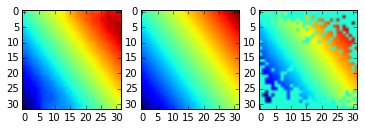

In [ ]:
subplot(1,3,1)
imshow(rec)
subplot(1,3,2)
imshow(f_refr)
subplot(1,3,3)
imshow(f_mr)

In [ ]:
from sklearn.feature_extraction.image import PatchExtractor as PE
ps = 8
pe = PE((8,8))
patches = reshape(pe.transform(array([f_mr])),(-1,ps*ps),order='C')
for i in range(patches.shape[0]):
    m = [np.random.rand() for j in range(len(patches[i,:])) if patches[i,j]==-100.]
    patches[i][patches[i]==-100.]= m
tempdic = MiniBatchDictionaryLearning(n_components=30, alpha=0.1, n_iter=5000 )
V = tempdic.fit(patches).components_    

//anaconda/envs/py3/lib/python3.4/site-packages/sklearn/linear_model/least_angle.py:170: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  elif Gram == 'auto':


In [ ]:
ps

5

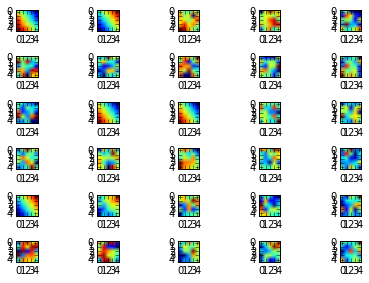

In [ ]:
for i,comp in enumerate(V):
    subplot(6,5,1+i)
    imshow(reshape(comp,(ps,ps)))
tight_layout()    

In [ ]:
from time import time as Ttime
t0=Ttime()
rec0 = image_rec(f_mr,V,1,ps,ps)
print(Ttime()-t0)

(8, 8)
shape of data (625, 64)
3.856797933578491


//anaconda/envs/py3/lib/python3.4/site-packages/sklearn/linear_model/coordinate_descent.py:444: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


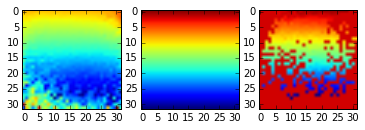

In [ ]:
subplot(1,3,1)
imshow(rec0)
subplot(1,3,2)
imshow(f_refr)
subplot(1,3,3)
imshow(f_mr)

In [ ]:
f_m[0,20,sl]

-100.0

# Data analysis

In [ ]:
np.unique(err[:,0])

array([  0.00000000e+00,   1.00000000e-03,   5.00000000e-03,
         1.00000000e-02,   5.00000000e-02,   1.00000000e-01,
         5.00000000e-01,   1.00000000e+00,   5.00000000e+00])

In [ ]:
dt_list=[0.5,0.1,0.05,0.01,0.005,0.001]
err = np.empty(err1.shape)
for dt in dt_list:
    err_temp = np.loadtxt("3d_err_dt_Ntraj_"+str(dt)+".txt")
    err = np.concatenate((err,err_temp),axis=0)

In [ ]:
err.shape

(162, 6)

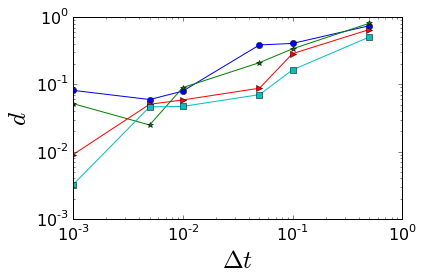

In [ ]:
#err1 = np.loadtxt("3d_err_dt_Ntraj.txt")
#err2 = np.loadtxt("3d_err_dt_Ntraj2.txt")
#err3 = np.loadtxt("3d_err_dt_Ntraj3.txt")
#err = np.concatenate((err3,err2,err1),axis=0)

dt_list=[0.5,0.1,0.05,0.01,0.005,0.001]
err = np.empty(err1.shape)
for dt in dt_list:
    err_temp = np.loadtxt("3d_err_dt_Ntraj_"+str(dt)+".txt")
    err = np.concatenate((err,err_temp),axis=0)
b = err.ravel().view(np.dtype((np.void, err.dtype.itemsize*err.shape[1])))
_, unique_idx = np.unique(b, return_index=True)

err = err[np.sort(unique_idx)]  
#err=res
figure(figsize = (6,4))
symb = ['o-','*-','>-','s-','D-','p-','^-']
#for k,i in enumerate(np.unique(err[:,1])):
for k,i in enumerate(array([500,1000,5000,10000])):
    l = [j for j in range(len(err[:,0])) if (err[j,1]==i and err[j,2]==100)]
    plot(err[l,0],err[l,3],symb[k],label = "$N_{traj}$ = "+str(int(i)))
    #legend(loc=4)
    xscale('log')
    yscale('log')
    #ylim(-0.001,0.008)
    xlabel('$\Delta t$',size = '25')
    ylabel('$d$',size = '25')
tick_params(axis='both', which='major', labelsize=16)    
tight_layout()
savefig("ofd/3d_err_vs_dt.pdf")

In [ ]:
new_array[1]

(0.01,
 200.0,
 400.0,
 0.30422427214708508,
 2719.0136372844563,
 0.69981129255232877)

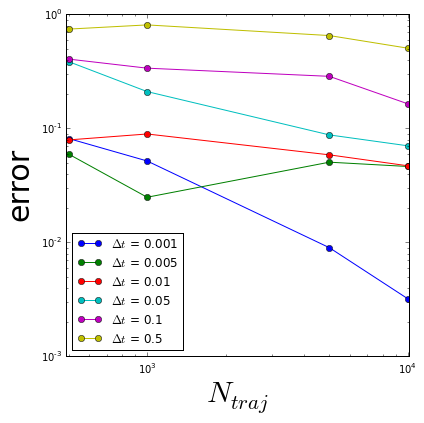

In [ ]:
figure(figsize = (6,6))
for i in np.unique(err[:,0]):
    l = [j for j in range(len(err[:,0])) if (err[j,0]==i and err[j,2]==100)]
    plot(err[l,1],err[l,3],'o-',label = "$\Delta t$ = "+str(i))
    legend(loc=3)
    xscale('log')
    xlim(490,10100)
    yscale('log')
    xlabel('$N_{traj}$',size = '30')
    ylabel('error',size = '30')
    
tight_layout()
savefig("3d_err_vs_Ntraj.pdf")

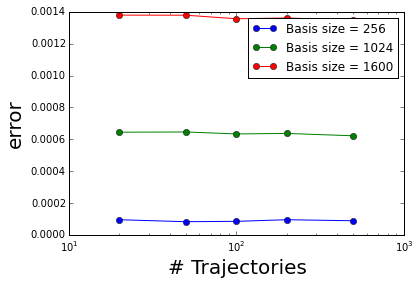

In [ ]:
for i in np.unique(res[:,2]):
    l = [j for j in range(len(res[:223,0])) if (res[j,2]==i and res[j,0]==0.1)]
    plot(res[l,1],res[l,3],'o-',label = "Basis size = "+str(int(i)))
    legend()
xscale('log')
xlabel('# Trajectories',size = '20')
ylabel('error',size = '20')

In [ ]:
l=[]
for i in range(1024//32):
    l.append(eval('f_m0['+str(i*32)+':'+str(i*32+32)+',:32]'))
#print(l)    

NameError: name 'f_m0' is not defined